### Load Packages

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.tseries.holiday import USFederalHolidayCalendar

### Set Config

In [2]:
data_dir = "/Users/mrla/Documents/Projects/data/flight_delays/ot_delaycause1_DL"
pd.set_option('display.max_columns', None)

# Use Seaborn's white theme with bold axes and soft gridlines
sns.set_theme(style="ticks", context="talk", palette="muted")

def plot_line(data, x, y, title, ylabel, figsize=(14, 6), hue=None):
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=data, x=x, y=y, hue=hue, linewidth=2.5)
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    sns.despine()  # removes top and right spines
    plt.tight_layout()
    plt.show()


### Load Data

In [3]:
df = pd.read_csv(data_dir + "/Airline_Delay_Cause.csv")


### Data Definitions ([Source](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?20=E))

![Data Definitions](DataDefinition.png)

### Data Exploration

#### High-level Data Summary

In [4]:
print(f"Shape of data: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
print(f"Columns in data: {df.columns.tolist()}")
print(f"First 5 rows of data:\n{df.head()}")


Shape of data: 400,118 rows, 21 columns
Columns in data: ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
First 5 rows of data:
   year  month carrier       carrier_name airport  \
0  2025      2      9E  Endeavor Air Inc.     ABE   
1  2025      2      9E  Endeavor Air Inc.     AEX   
2  2025      2      9E  Endeavor Air Inc.     AGS   
3  2025      2      9E  Endeavor Air Inc.     ALB   
4  2025      2      9E  Endeavor Air Inc.     ATL   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         78.0        9.0   
1           Alexandria, LA: Alexandria International         78.0       12.0   
2        Augusta, GA: Augusta Regional at Bush Field   

In [5]:
print(f"Data types of columns:\n{df.dtypes}")
print("--------------------------------")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
})

print("Missing values in each column:\n", missing_df)

print("--------------------------------")
print(f"Summary statistics of numerical columns:\n{df.describe()}")

Data types of columns:
year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object
--------------------------------
Missing values in each column:
                      Missing Count  Missing %
year                             0       0.00
month                            0       0.00
carrier                          0       0.00
carrier_name                     0       0.00
airport          

##### Insights so far

🧭 Understanding `*_ct` and `*_delay` Columns

🔹 `*_ct` Columns (e.g., `carrier_ct`, `weather_ct`)

* Despite the name, these are **not raw integer counts** of delays.
* They contain **decimal values**, indicating they are likely:

  * **Weighted averages** (e.g., delays per flight or per day)
  * **Proportional allocations** of delay causes
* These fields are typically found in **aggregated FAA datasets** where counts are normalized.
* **Important**: We **cannot** sum the `*_ct` values expecting to get total delayed flights (`arr_del15`).

🔹 `*_delay` Columns (e.g., `carrier_delay`, `weather_delay`)

* These represent **delay durations in minutes**.
* In principle, their **sum should match** `arr_delay`:

  ```
  arr_delay ≈ carrier_delay + weather_delay + nas_delay + security_delay + late_aircraft_delay
  ```
* In practice, small mismatches may exist due to:

  * Rounding
  * Missing values
  * Unattributed or jointly caused delays

---

👉 **In the next code section, we will check if the delay components add up to `arr_delay` and explore any mismatches.**


In [6]:
# Step 1: Safely compute delay component sum by treating NaNs as 0
delay_components = (
    df['carrier_delay'].fillna(0) +
    df['weather_delay'].fillna(0) +
    df['nas_delay'].fillna(0) +
    df['security_delay'].fillna(0) +
    df['late_aircraft_delay'].fillna(0)
)

# Step 2: Compute difference from arr_delay (only where arr_delay is not null)
valid_mask = df['arr_delay'].notna()
delay_difference = df.loc[valid_mask, 'arr_delay'] - delay_components[valid_mask]

# Step 3: Identify rows where the difference is significant (e.g., > 1 minute)
mismatched_rows = df.loc[valid_mask].loc[delay_difference.abs() > 1]

# Step 4: Summary
print(f"Total valid rows (non-null arr_delay): {valid_mask.sum()}")
print(f"Rows where delay components do NOT sum to arr_delay: {len(mismatched_rows)} ({(len(mismatched_rows) / len(df)) * 100:.2f}%)")

print("\nSample mismatches:")
print(
    mismatched_rows[['arr_delay']].assign(
        delay_components=delay_components[valid_mask],
        difference=delay_difference
    ).head()
)




Total valid rows (non-null arr_delay): 399461
Rows where delay components do NOT sum to arr_delay: 9 (0.00%)

Sample mismatches:
       arr_delay  delay_components  difference
13845    39334.0           39154.0       180.0
13848    12812.0           12686.0       126.0
25479     2773.0            1428.0      1345.0
28886     6934.0            6880.0        54.0
31638     3006.0            2775.0       231.0


Out of 399,461 valid records (i.e., rows where `arr_delay` is not null), only 9 rows—or less than 0.01%—have a mismatch between the sum of individual delay components (`carrier_delay`, `weather_delay`, `nas_delay`, `security_delay`, `late_aircraft_delay`) and the reported `arr_delay`. This confirms that the delay decomposition is highly reliable across the dataset. The mismatches are relatively small in scale, with the largest observed difference being 1,345 minutes. These discrepancies could be due to rounding, reporting errors, or rare cases of unclassified delays. 

Overall, the dataset's delay attribution can be considered consistent and trustworthy for modeling time series and anomaly detection.


#### Yearly Stats

In [7]:
import pandas as pd

# Add a 'season' column to the original DataFrame
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Yearly aggregated DataFrame
yearly_df = (
    df.groupby('year')
    .agg(
        n_airports=('airport', pd.Series.nunique),
        n_carriers=('carrier', pd.Series.nunique),
        total_arr_flights=('arr_flights', 'sum'),
        pct_delayed=('arr_del15', lambda x: x.sum() / df.loc[x.index, 'arr_flights'].sum()),
        avg_arr_delay=('arr_delay', 'mean'),
        avg_carrier_delay=('carrier_delay', 'mean'),
        avg_weather_delay=('weather_delay', 'mean'),
        avg_nas_delay=('nas_delay', 'mean'),
        avg_security_delay=('security_delay', 'mean'),
        avg_late_aircraft_delay=('late_aircraft_delay', 'mean')
    )
    .reset_index()
)

# Seasonal aggregated DataFrame
seasonal_df = (
    df.groupby(['year', 'season'])
    .agg(
        n_airports=('airport', pd.Series.nunique),
        n_carriers=('carrier', pd.Series.nunique),
        total_arr_flights=('arr_flights', 'sum'),
        pct_delayed=('arr_del15', lambda x: x.sum() / df.loc[x.index, 'arr_flights'].sum()),
        avg_arr_delay=('arr_delay', 'mean'),
        avg_carrier_delay=('carrier_delay', 'mean'),
        avg_weather_delay=('weather_delay', 'mean'),
        avg_nas_delay=('nas_delay', 'mean'),
        avg_security_delay=('security_delay', 'mean'),
        avg_late_aircraft_delay=('late_aircraft_delay', 'mean')
    )
    .reset_index()
)

# Optional: Ensure natural season order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_df['season'] = pd.Categorical(seasonal_df['season'], categories=season_order, ordered=True)
seasonal_df = seasonal_df.sort_values('season')


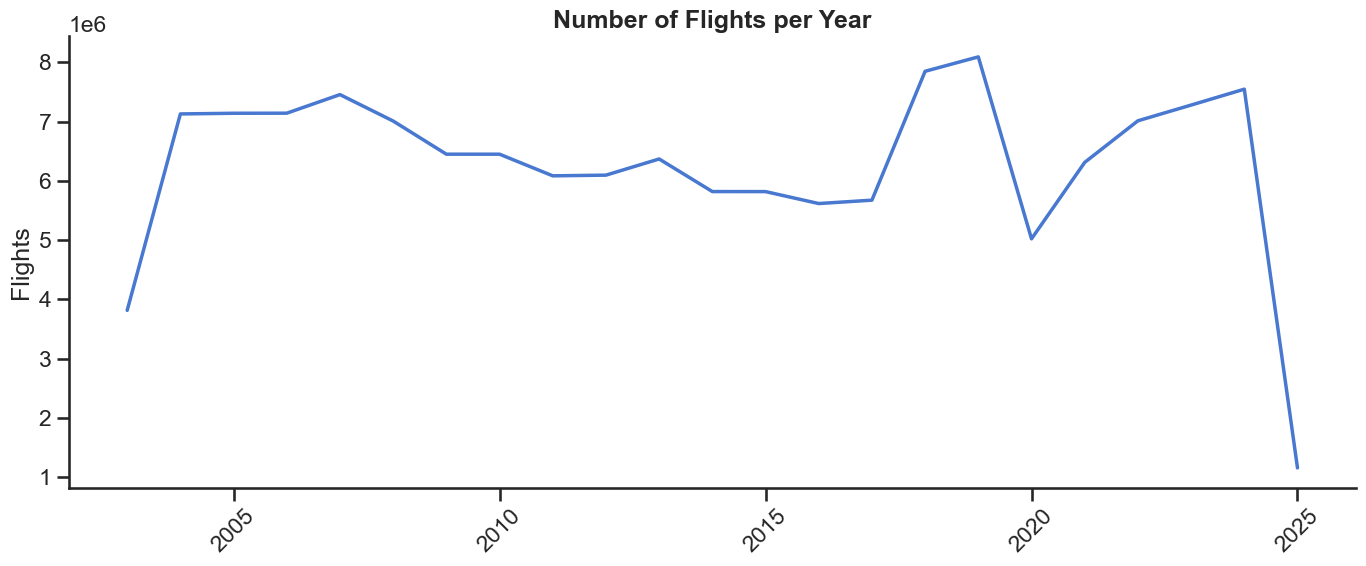

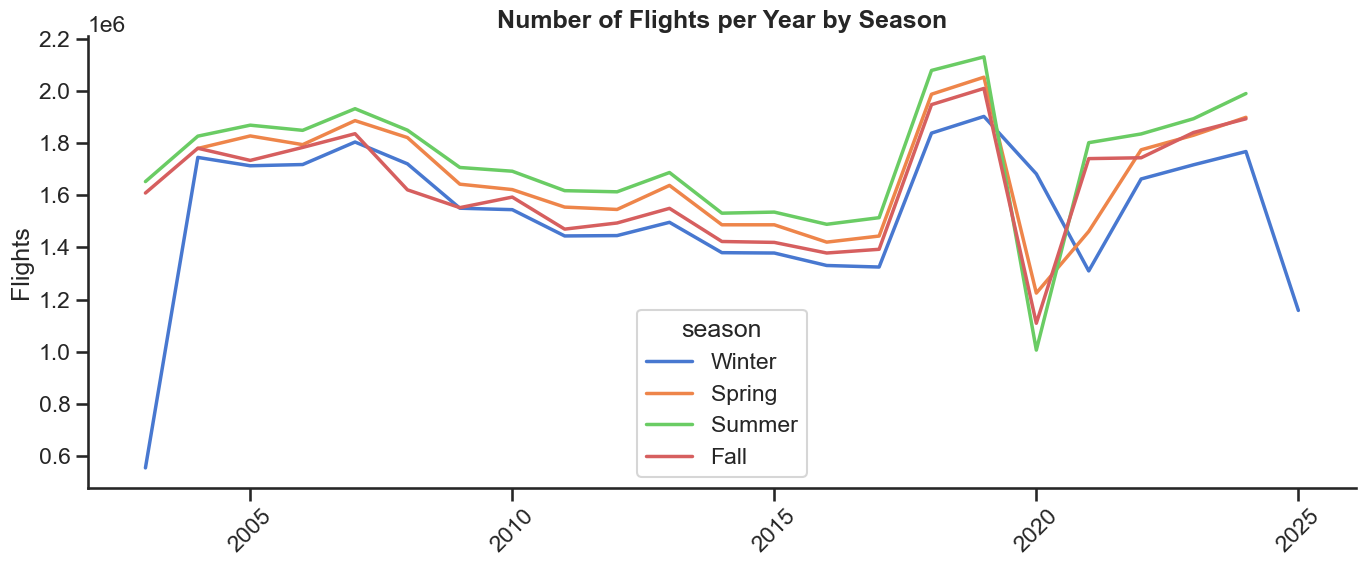

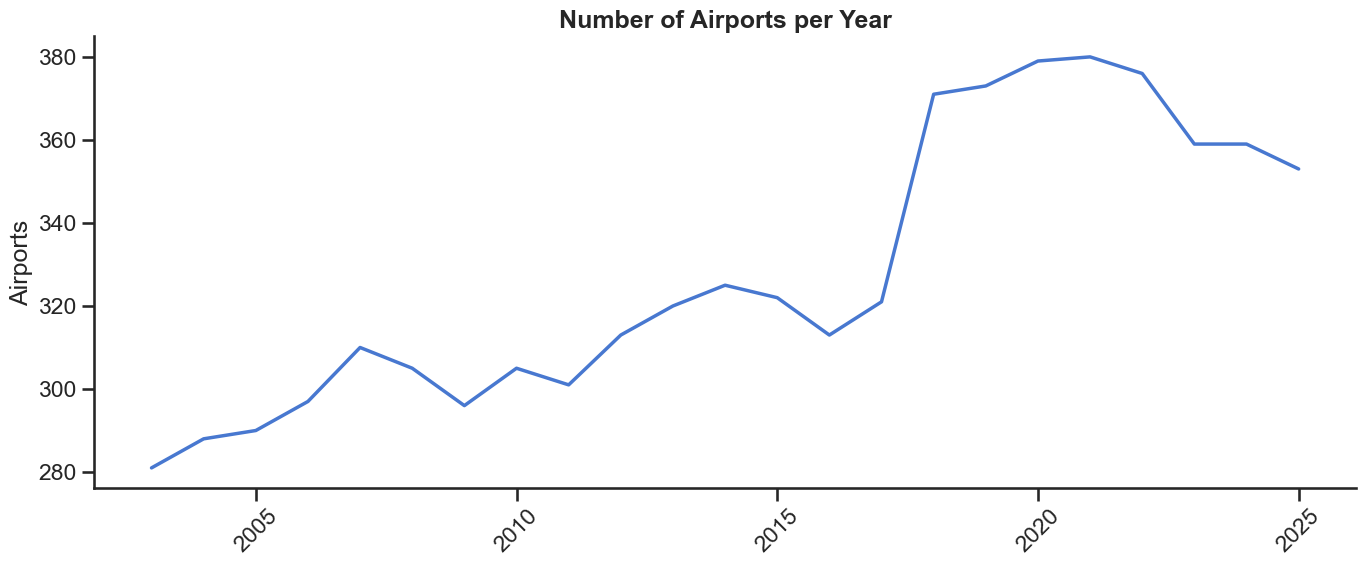

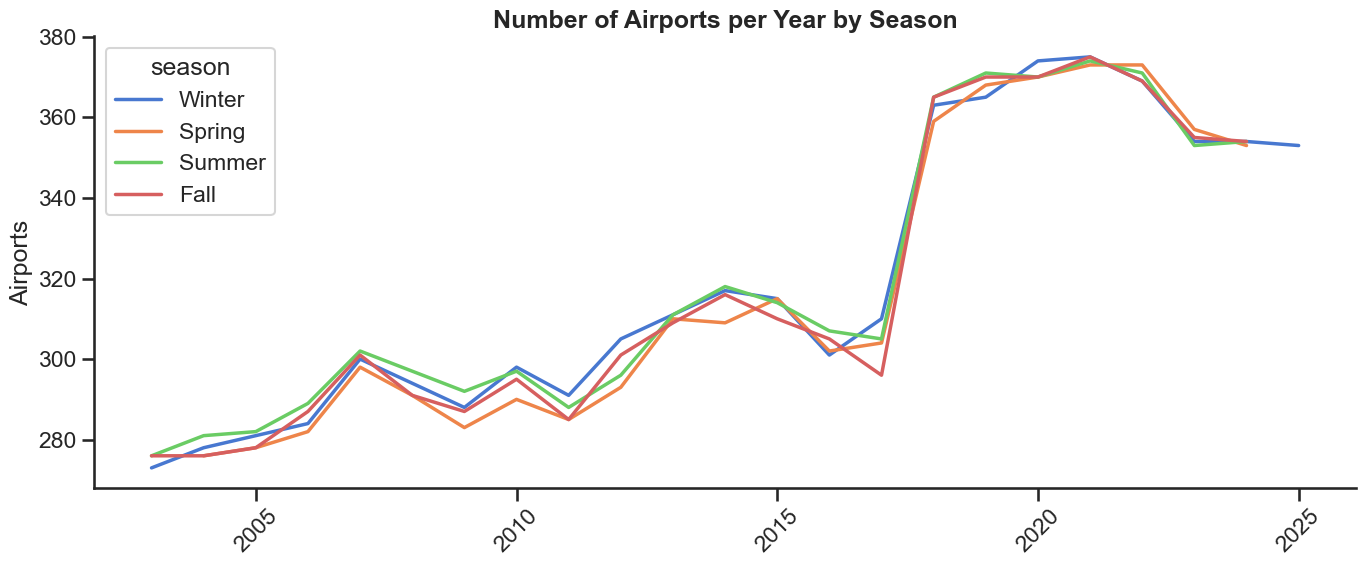

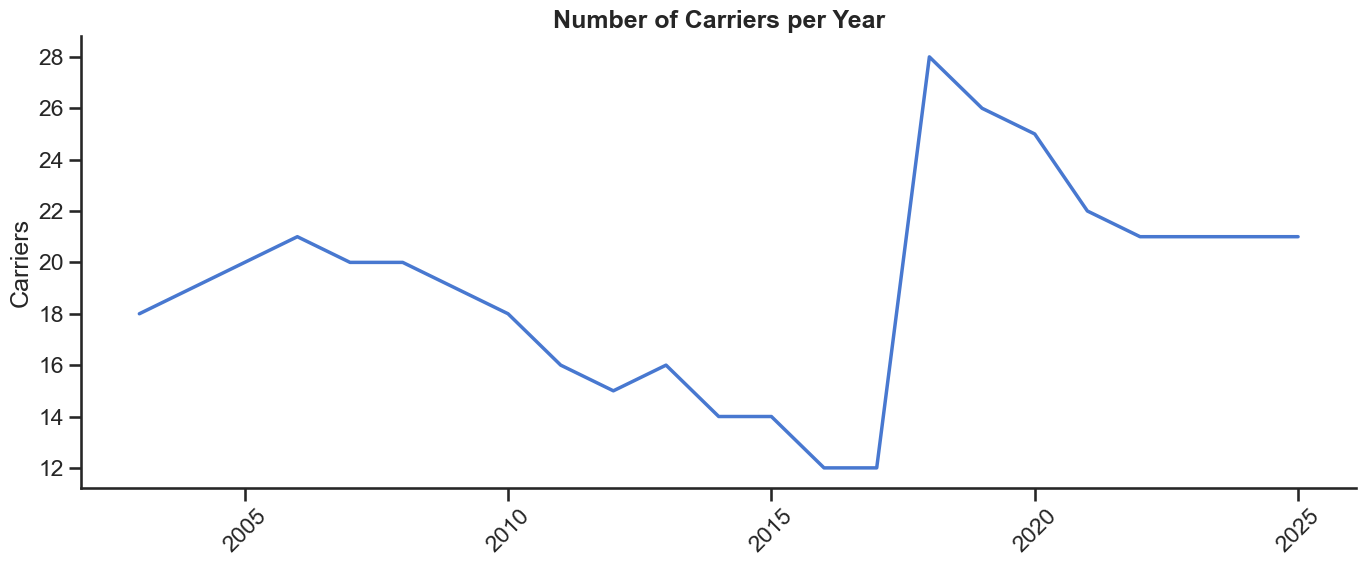

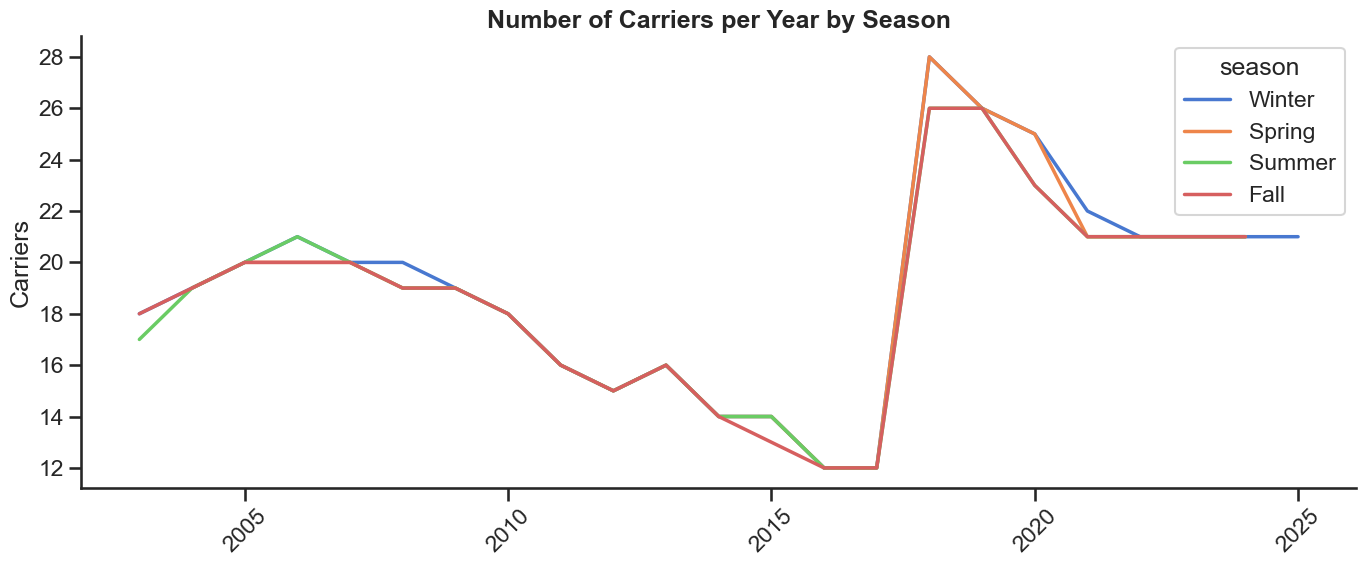

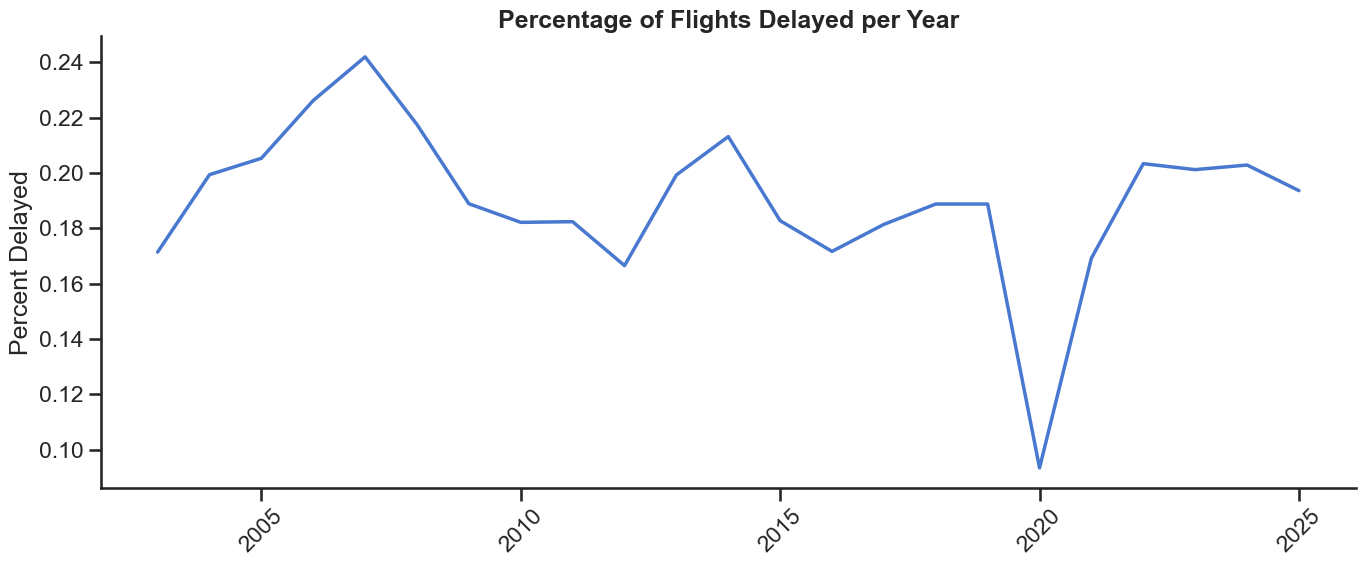

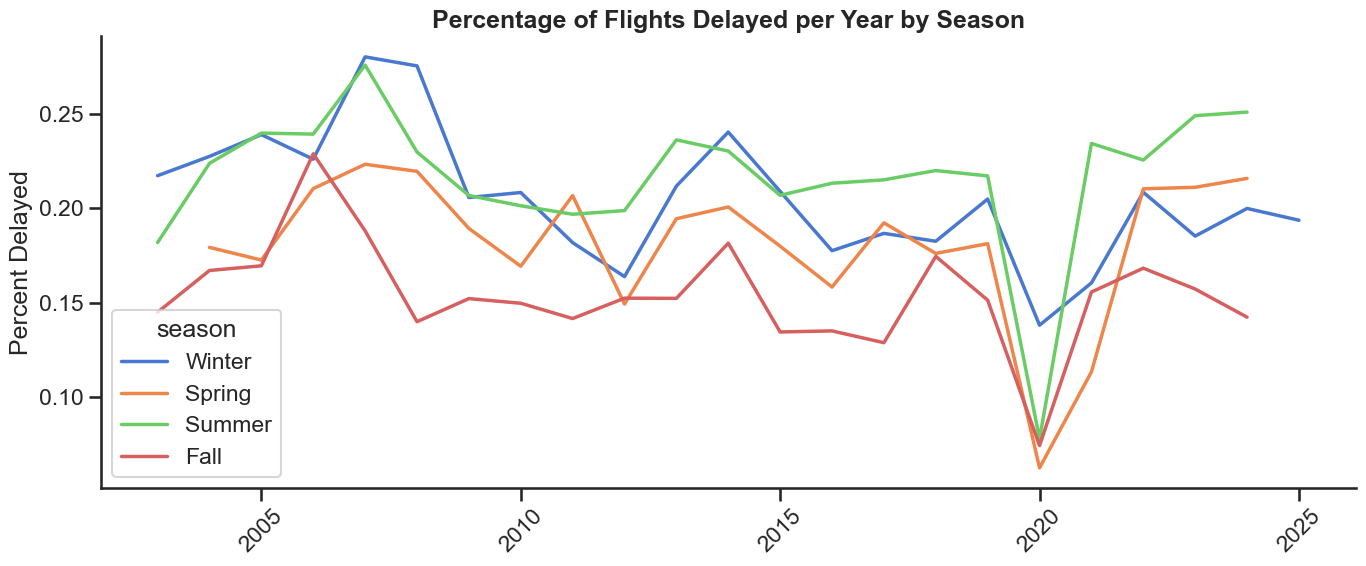

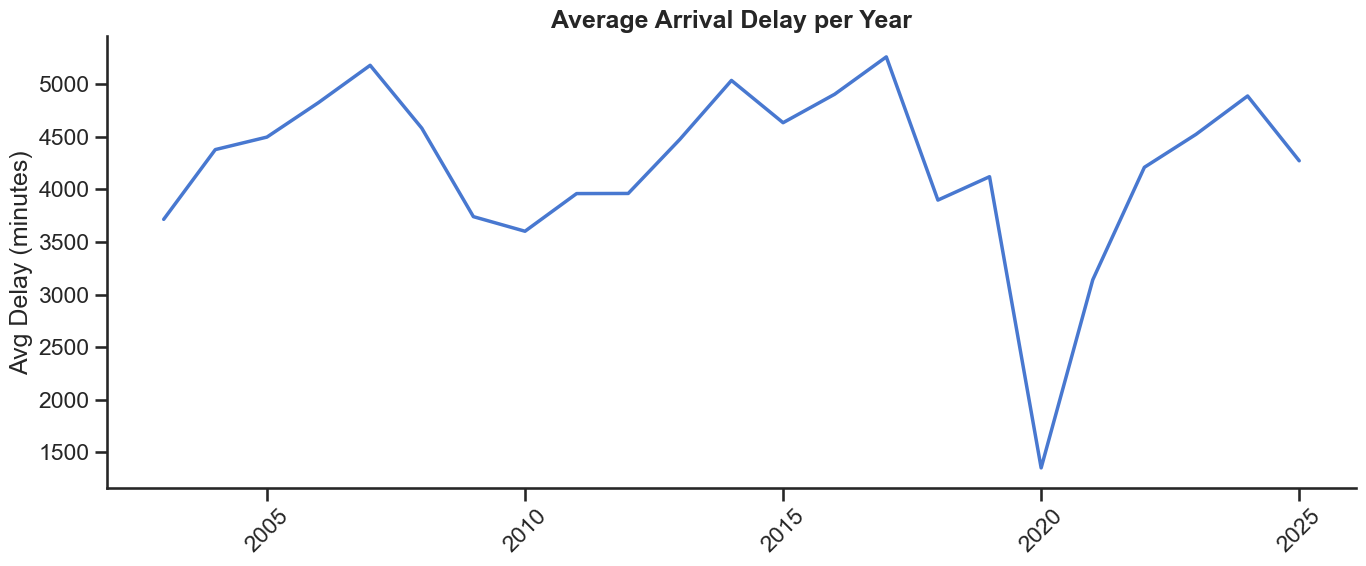

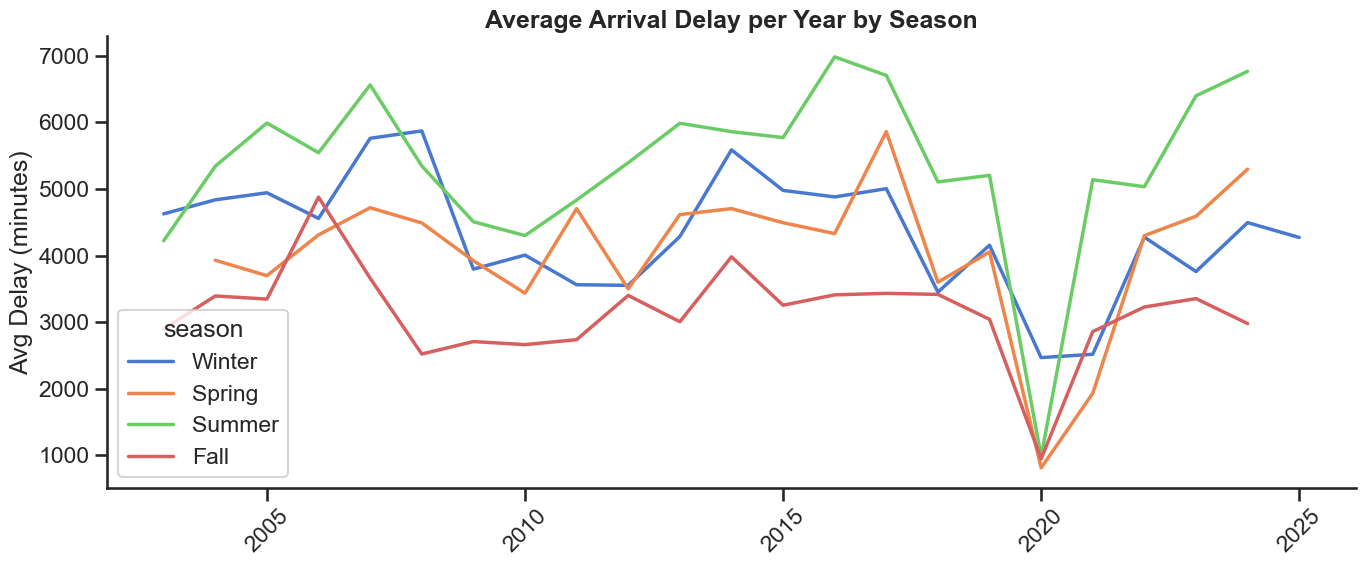

In [8]:
# Plot 1: Number of Flights
plot_line(yearly_df, x='year', y='total_arr_flights',
          title='Number of Flights per Year', ylabel='Flights')

plot_line(seasonal_df, x='year', y='total_arr_flights', hue='season',
          title='Number of Flights per Year by Season', ylabel='Flights')

# Plot 2: Number of Airports
plot_line(yearly_df, x='year', y='n_airports',
          title='Number of Airports per Year', ylabel='Airports')

plot_line(seasonal_df, x='year', y='n_airports', hue='season',
          title='Number of Airports per Year by Season', ylabel='Airports')

# Plot 3: Number of Carriers
plot_line(yearly_df, x='year', y='n_carriers',
          title='Number of Carriers per Year', ylabel='Carriers')

plot_line(seasonal_df, x='year', y='n_carriers', hue='season',
          title='Number of Carriers per Year by Season', ylabel='Carriers')

# Plot 4: Percentage of Flights Delayed
plot_line(yearly_df, x='year', y='pct_delayed',
          title='Percentage of Flights Delayed per Year', ylabel='Percent Delayed')

plot_line(seasonal_df, x='year', y='pct_delayed', hue='season',
          title='Percentage of Flights Delayed per Year by Season', ylabel='Percent Delayed')

# Plot 5: Average Arrival Delay
plot_line(yearly_df, x='year', y='avg_arr_delay',
          title='Average Arrival Delay per Year', ylabel='Avg Delay (minutes)')

plot_line(seasonal_df, x='year', y='avg_arr_delay', hue='season',
          title='Average Arrival Delay per Year by Season', ylabel='Avg Delay (minutes)')


Some insights so far:
* **Data prior to 2005**
  * The dataset is incomplete for years before 2005, with only a few carriers represented.
  * Data prior to this will be excluded

* **Impact of Covid-19**
  * The data in 2020 seems to be heavily impacted by the Covid-19 pandemic, with significant drops in flight activity and delays.
  * Data in 2023  seems to have returned to pre-pandemic levels, but with some lingering effects.
  * Data in 2025 is incomplete therefore will not be included in this analysis.

However, we can see that there is some anomaly in the number of `airport`s and  `carrier`s in 2017. The spike seems too high and it warrants further investigation. 

#### Flights of Carriers per year

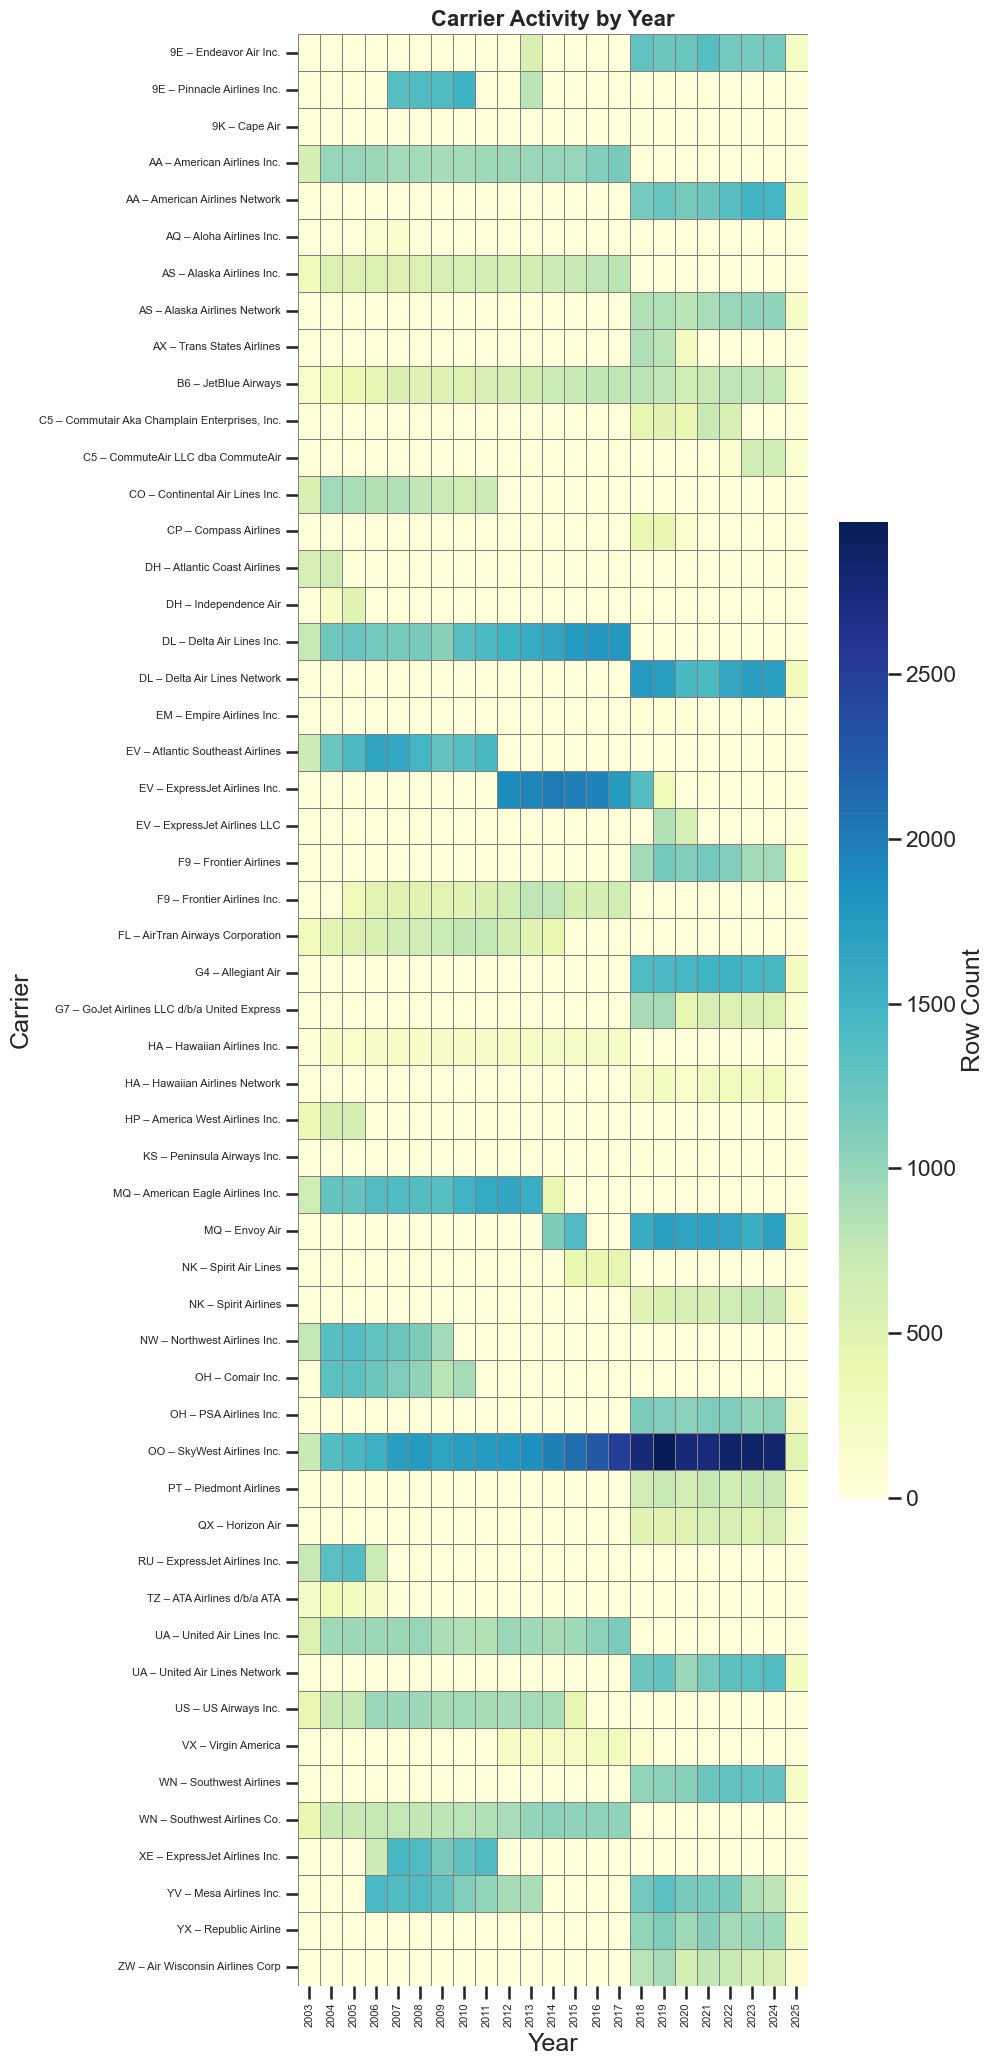

In [9]:

# Pivot table with carriers on rows and years on columns
carrier_year_matrix = (
    df.groupby(['carrier', 'carrier_name', 'year'])
    .size()
    .reset_index(name='n_rows')
    .pivot_table(
        index=['carrier', 'carrier_name'],
        columns='year',
        values='n_rows',
        fill_value=0
    )
)

# Create a readable label: "XX – Carrier Name"
carrier_year_matrix.index = carrier_year_matrix.index.map(
    lambda x: f"{x[0]} – {x[1]}"
)

# Create heatmap
plt.figure(figsize=(10, int(len(carrier_year_matrix) * 0.4)))
sns.heatmap(
    carrier_year_matrix,
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Row Count',
              'shrink': 0.5,
              'aspect': 20,
                     
              },
    square=False,
    label=True,
    
)
plt.title("Carrier Activity by Year", fontsize=16, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Carrier")
plt.tick_params(axis='y', labelsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()
plt.show()


The dataset reveals several structural inconsistencies that should be considered before conducting trend analysis or forecasting:

* **Missing Historical Presence**

  * Some long-established carriers (e.g., Piedmont Airlines) only appear in recent years.
  * This likely reflects changes in reporting scope or operational status (e.g., reactivation after mergers).

* **Carrier Code vs. Carrier Name Mismatch**

  * The same carrier code is reused over time but tied to different carrier names.

    * Example: `"EV"` appears as both *ExpressJet Airlines Inc.* and *ExpressJet Airlines LLC*.
  * This creates ambiguity in time series analysis, especially when aggregating or tracking carrier performance longitudinally.

* **Irregular or Short-Lived Carriers**

  * Some carriers operate only for limited periods or on seasonal routes (e.g., Endeavor Air Inc, Peninsula Airways, Mesa Airlines Inc.).
  * These entries can distort long-term trends if not filtered or labeled appropriately.

For this analysis, we will:
  * Combine the carrier names filghts into the same carrier code
  * Focus only on carriers with a consistent presence across the dataset, e.g. Delta Airlines, JetBlue, United, etc.


#### Flights in Each Airport per Year

In [17]:
# Pivot table with airports on rows and years on columns
airport_year_matrix = (
    df.groupby(['airport', 'airport_name', 'year'])
    .size()
    .reset_index(name='n_rows')
    .pivot_table(
        index=['airport', 'airport_name'],
        columns='year',
        values='n_rows',
        fill_value=0
    )
)

# Create a readable label: "XXX – Airport Name"
airport_year_matrix.index = airport_year_matrix.index.map(
    lambda x: f"{x[0]} – {x[1]}"
)

# Transpose the matrix: now years = rows, airports = columns
airport_year_matrix = airport_year_matrix.T

fig = px.imshow(
    airport_year_matrix,
    labels=dict(x="Airport", y="Year", color="Row Count"),
    aspect="auto",
    color_continuous_scale="YlGnBu"
)

fig.update_layout(
    width=3000,  # adjust as needed
    height=600,
    title="Airport Activity by Year",
    xaxis_tickangle=45,
    xaxis=dict(
        tickfont=dict(size=8)  # smaller x-axis font
    ),
    yaxis=dict(
        tickfont=dict(size=10)  # smaller y-axis font
    )
)

fig.show()


Similar to the `carrier` data, the `airport` data also has some inconsistencies that should be considered before conducting trend analysis or forecasting:
* Airports like PVD in Providence, RI, and LAS Las Vegas show different airports but are actually the same airport. In the case of LAS, it is a common mistake to use the airport code for McCarran International Airport, which is now Harry Reid International Airport.

For this analysis, we will only consider flights from airports with high flight activity and a consistent presence across the dataset, e.g. LAS, LGA, MCI, etc.

Note: The plotly above is zoomed to showcase similar issues in the `airport` data, you can click on the Zoom controls and explore other airports.

#### Monthly stats

In [11]:
monthly_stats = (
    df.groupby(['year', 'month'])
    .agg(
        n_rows=('airport', 'count'),
        n_airports=('airport', pd.Series.nunique),
        n_carriers=('carrier', pd.Series.nunique),
        total_arr_flights=('arr_flights', 'sum'),
        total_arr_del15=('arr_del15', 'sum'),
        total_arr_delay=('arr_delay', 'sum'),
        avg_arr_delay=('arr_delay', 'mean'),
        max_arr_delay=('arr_delay', 'max'),
        avg_carrier_delay=('carrier_delay', 'mean'),
        avg_weather_delay=('weather_delay', 'mean'),
        avg_nas_delay=('nas_delay', 'mean'),
        avg_security_delay=('security_delay', 'mean'),
        avg_late_aircraft_delay=('late_aircraft_delay', 'mean'),
        total_cancelled=('arr_cancelled', 'sum'),
        total_diverted=('arr_diverted', 'sum')
    )
    .reset_index()
)

# Derived metrics
monthly_stats['pct_delayed'] = (
    monthly_stats['total_arr_del15'] / monthly_stats['total_arr_flights']
)
monthly_stats['cancel_rate'] = (
    monthly_stats['total_cancelled'] / monthly_stats['total_arr_flights']
)
monthly_stats['divert_rate'] = (
    monthly_stats['total_diverted'] / monthly_stats['total_arr_flights']
)

# Create a datetime column for monthly x-axis
monthly_stats['date'] = pd.to_datetime(
    monthly_stats[['year', 'month']].assign(day=1)
)


display(monthly_stats)

,year,month,n_rows,n_airports,n_carriers,total_arr_flights,total_arr_del15,total_arr_delay,avg_arr_delay,max_arr_delay,avg_carrier_delay,avg_weather_delay,avg_nas_delay,avg_security_delay,avg_late_aircraft_delay,total_cancelled,total_diverted,pct_delayed,cancel_rate,divert_rate,date
0,2003,6,1248,275,17,536496.0,89441.0,4227088.0,3395.251406,117195.0,969.285141,227.465863,1120.414458,17.656225,1060.429719,4161.0,1025.0,0.166713,0.007756,0.001911,2003-06-01
1,2003,7,1249,274,17,558568.0,104579.0,5733157.0,4590.197758,179831.0,1188.594876,323.345076,1555.261009,6.933547,1516.063251,7835.0,1205.0,0.187227,0.014027,0.002157,2003-07-01
2,2003,8,1247,272,17,556984.0,106326.0,5838770.0,4682.253408,168637.0,1208.034483,353.981556,1639.234162,10.596632,1470.406576,9109.0,1517.0,0.190896,0.016354,0.002724,2003-08-01
3,2003,9,1248,272,17,527714.0,67386.0,3207097.0,2575.981526,119787.0,671.893976,128.764659,1065.053012,2.375100,707.894779,7691.0,771.0,0.127694,0.014574,0.001461,2003-09-01
4,2003,10,1246,268,17,552370.0,69394.0,3059671.0,2455.594703,102272.0,749.666132,91.227127,865.081862,9.168539,740.451043,5091.0,720.0,0.125630,0.009217,0.001303,2003-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2024,10,1877,352,21,656283.0,84806.0,5187832.0,2765.368870,163335.0,1171.896588,91.638593,453.036780,4.845416,1043.951493,6314.0,747.0,0.129222,0.009621,0.001138,2024-10-01
257,2024,11,1877,349,21,614597.0,89260.0,5672829.0,3023.896055,206051.0,1099.942431,162.930171,655.583156,4.515458,1100.924840,2804.0,908.0,0.145233,0.004562,0.001477,2024-11-01
258,2024,12,1926,352,21,631944.0,132515.0,9585044.0,4979.243636,303265.0,1675.266494,381.690390,875.914805,7.311688,2039.060260,4579.0,1752.0,0.209694,0.007246,0.002772,2024-12-01
259,2025,1,1916,352,21,599013.0,109605.0,7872217.0,4108.672756,305779.0,1446.031837,373.798017,810.160230,5.692589,1472.990084,18740.0,1316.0,0.182976,0.031285,0.002197,2025-01-01


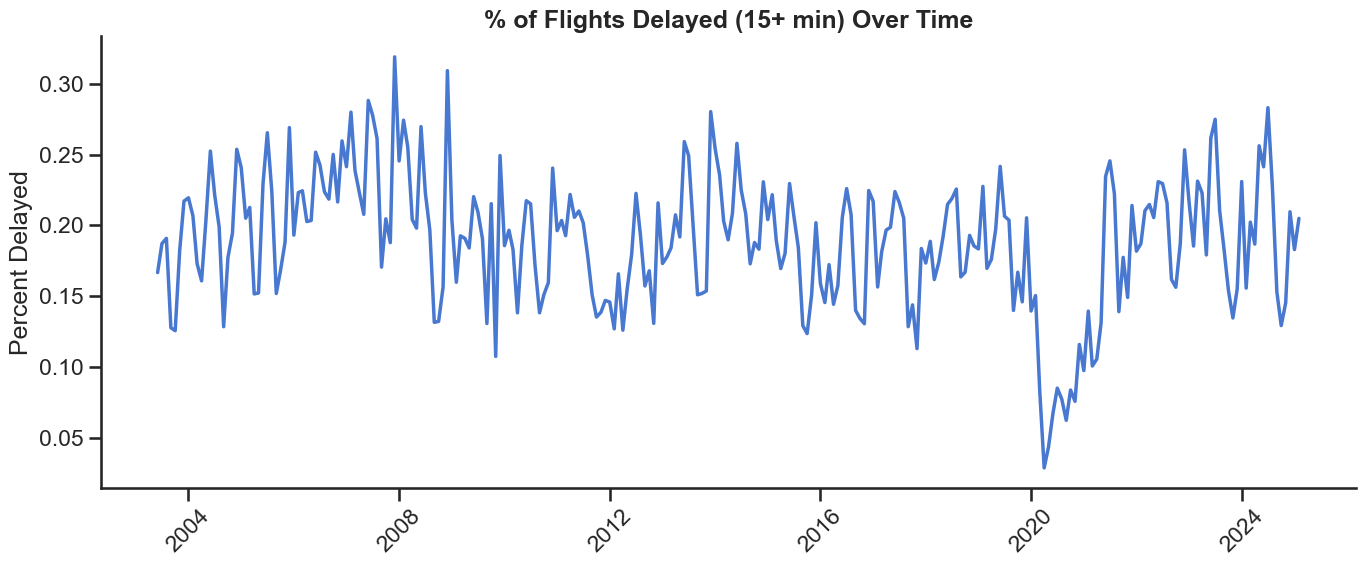

In [12]:
plot_line(
    data=monthly_stats,
    x='date',
    y='pct_delayed',
    title='% of Flights Delayed (15+ min) Over Time',
    ylabel='Percent Delayed'
)

* Delay rates increased steadily from 2003 to around 2008, likely due to rising air traffic and limited infrastructure.
* From 2008 to 2015, delay rates showed high volatility but no consistent trend, possibly due to airline mergers and operational adjustments.
* Clear seasonal patterns appear each year, with delays peaking in winter and summer months, indicating strong seasonality.
* A sharp decline in delay percentage occurred in early 2020 due to the COVID-19 pandemic and associated drop in flight volume.
* Post-2020, delay rates gradually returned with noticeable fluctuations, suggesting an uneven recovery and potential operational strain.
* The current (2023–2024) delay levels have reached pre-COVID variability, showing a full rebound in system usage and disruption patterns.


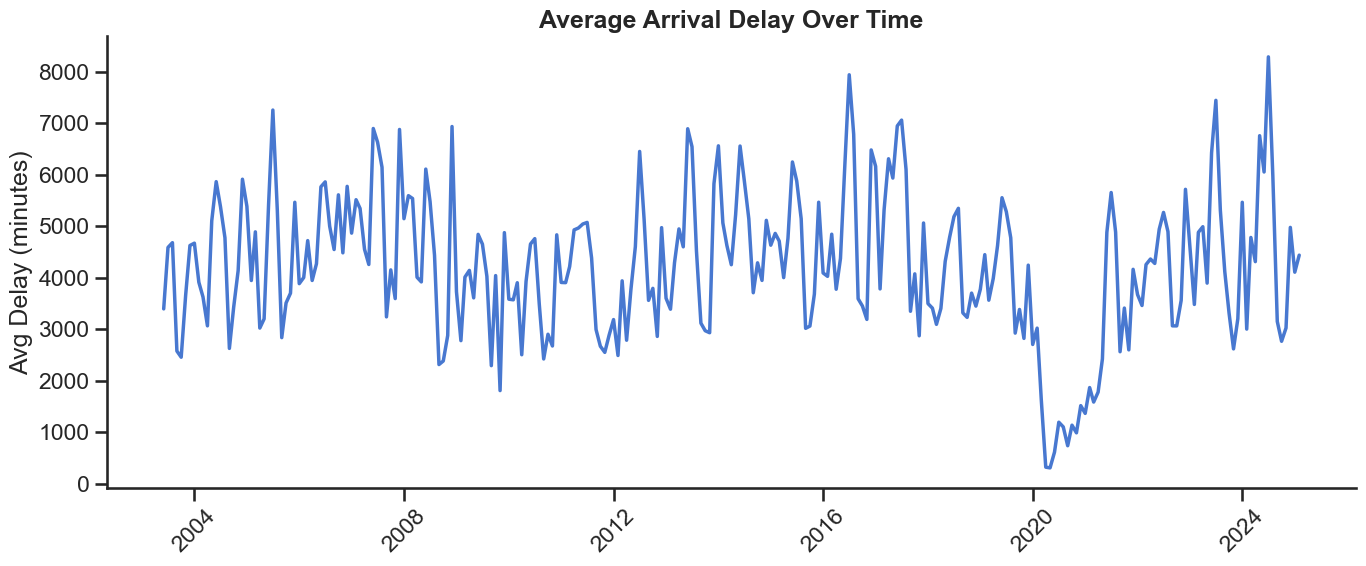

In [13]:
plot_line(
    data=monthly_stats,
    x='date',
    y='avg_arr_delay',
    title='Average Arrival Delay Over Time',
    ylabel='Avg Delay (minutes)'
)


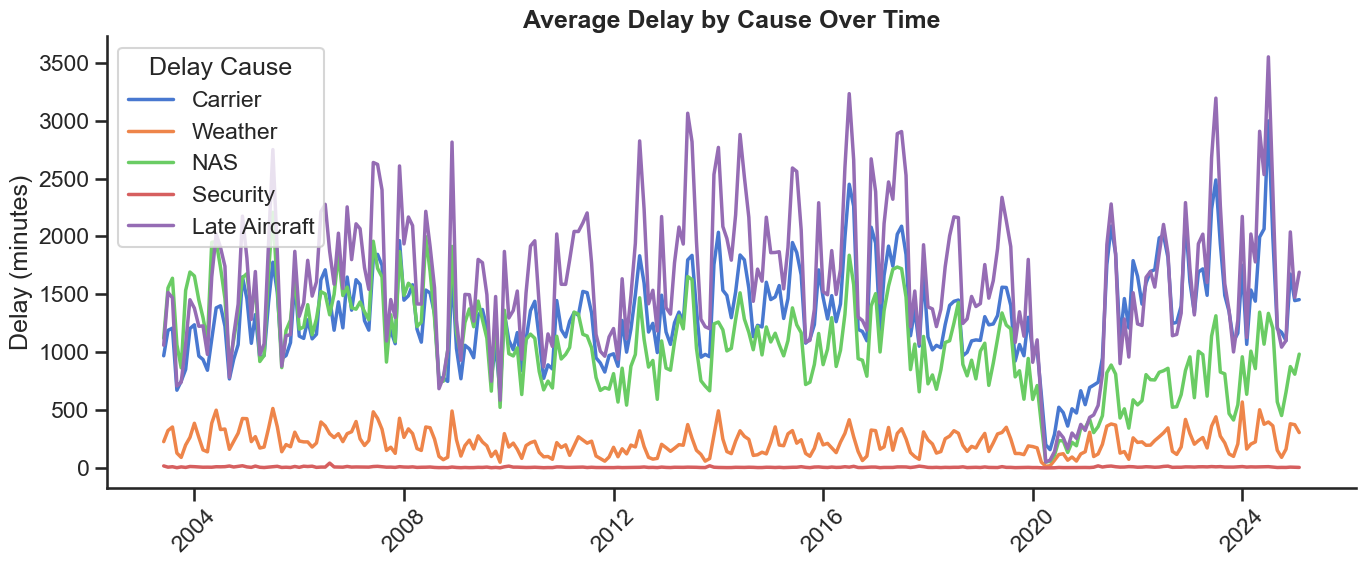

In [14]:
plt.figure(figsize=(14, 6))
delay_cols = {
    'avg_carrier_delay': 'Carrier',
    'avg_weather_delay': 'Weather',
    'avg_nas_delay': 'NAS',
    'avg_security_delay': 'Security',
    'avg_late_aircraft_delay': 'Late Aircraft'
}

for col, label in delay_cols.items():
    sns.lineplot(data=monthly_stats, x='date', y=col, label=label, linewidth=2.5)

plt.title('Average Delay by Cause Over Time', fontsize=18, fontweight='bold')
plt.ylabel('Delay (minutes)')
plt.xlabel('')
plt.legend(title='Delay Cause')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


* **Late aircraft delays** consistently cause the highest average monthly delay, making it the dominant contributor across all years.
* **Carrier-related delays** are the second most significant cause, closely following late aircraft delays in trend and seasonality.
* **NAS (National Aviation System) delays** also contribute significantly, with moderate seasonal fluctuations, and appear to increase again post-2020.
* **Weather delays** are relatively low but highly seasonal, with visible spikes likely aligned with winter storms or summer disruptions.
* **Security delays** are negligible across the entire timeline and show minimal variance, indicating they have little impact on total delays.
* A steep drop in all delay causes occurred in early 2020, reflecting the COVID-19 impact — followed by a sharp recovery and increased variability in 2022–2024.
* Post-COVID, late aircraft and carrier delays show **more volatility and sharper spikes**, suggesting growing operational strain or irregularities in flight schedules.


In [15]:
# Step 1: Create a monthly grouped dataset
monthly_group = (
    df.groupby(['year', 'month', 'airport', 'carrier'])
    .agg(
        avg_flights=('arr_flights', 'mean'),
        avg_delays=('arr_del15', 'mean'),
        count_months=('arr_flights', 'count')
    )
    .reset_index()
)

# Step 2: Create a unique key for pair and calculate summary stats
monthly_group['pair'] = monthly_group['airport'] + ' - ' + monthly_group['carrier']

# Step 3: Rank pairs by:
# - number of months of data
# - average monthly volume
pair_summary = (
    monthly_group.groupby('pair')
    .agg(
        total_months=('count_months', 'sum'),
        avg_monthly_flights=('avg_flights', 'mean'),
        avg_monthly_delays=('avg_delays', 'mean')
    )
    .reset_index()
)

# Step 4: Filter and sort to find good candidates
good_pairs = pair_summary.query("total_months >= 36")  # e.g., at least 3 years of data

top_pairs = good_pairs.sort_values(
    by=['avg_monthly_flights', 'avg_monthly_delays'],
    ascending=False
)

# Display top 10 candidates
top_pairs.head(10)


,pair,total_months,avg_monthly_flights,avg_monthly_delays
179,ATL - DL,261,16874.681992,2573.915709
1138,DFW - AA,261,12623.988506,2271.264368
2814,MSP - NW,79,7839.443038,1439.898734
1237,DTW - NW,79,7680.924051,1378.000000
1939,IAH - RU,37,7408.864865,1335.432432
1943,IAH - XE,66,7257.984848,1305.833333
180,ATL - EV,201,7145.427861,1678.980100
865,CLT - US,145,6878.475862,1127.041379
1927,IAH - CO,103,6823.000000,1116.135922
3046,ORD - UA,261,6319.363985,1207.459770


### Add Features

#### Holidays per month

In [22]:
# Define the date range
start_date = '2005-01-01'
end_date = '2024-12-31'

# Create calendar and get holidays in that range
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=start_date, end=end_date)

# Convert to DataFrame with year and month
holidays_df = pd.DataFrame({'date': holidays})
holidays_df['year'] = holidays_df['date'].dt.year
holidays_df['month'] = holidays_df['date'].dt.month

# Count holidays by (year, month)
monthly_flags = (
    holidays_df.groupby(['year', 'month'])
    .size()
    .reset_index(name='num_holidays')
)

# Fill in missing (year, month) pairs with 0 holidays
all_months = pd.MultiIndex.from_product(
    [range(2005, 2016), range(1, 13)],
    names=['year', 'month']
)

monthly_flags = (
    monthly_flags
    .set_index(['year', 'month'])
    .reindex(all_months, fill_value=0)
    .reset_index()
)

# Preview
print(monthly_flags.head(12))  # first year

    year  month  num_holidays
0   2005      1             1
1   2005      2             1
2   2005      3             0
3   2005      4             0
4   2005      5             1
5   2005      6             0
6   2005      7             1
7   2005      8             0
8   2005      9             1
9   2005     10             1
10  2005     11             2
11  2005     12             1


#### Holiday/travel season flag
* Summer travel: June, July, August

* Holiday travel: November (Thanksgiving), December (Christmas/New Year)

Source: [TSA Throughput Data](https://www.tsa.gov/coronavirus/passenger-throughput), [DOT Bureau of Transportation Statistics](https://www.transtats.bts.gov/)

In [23]:
monthly_flags['travel_season_flag'] = monthly_flags['month'].isin([6, 7, 8, 11, 12]).astype(int)
# Preview
print(monthly_flags.head(12))  # first year

    year  month  num_holidays  travel_season_flag
0   2005      1             1                   0
1   2005      2             1                   0
2   2005      3             0                   0
3   2005      4             0                   0
4   2005      5             1                   0
5   2005      6             0                   1
6   2005      7             1                   1
7   2005      8             0                   1
8   2005      9             1                   0
9   2005     10             1                   0
10  2005     11             2                   1
11  2005     12             1                   1


In [26]:
monthly_flags['date'] = pd.to_datetime(monthly_flags[['year', 'month']].assign(day=1))

# 1. COVID-19: March 2020 to March 2022
monthly_flags['covid_flag'] = (
    (monthly_flags['date'] >= '2020-03-01') & (monthly_flags['date'] <= '2022-03-01')
).astype(int)

# 2. Recession (Dec 2007 – Jun 2009)
monthly_flags['recession_flag'] = (
    (monthly_flags['date'] >= '2007-12-01') & (monthly_flags['date'] <= '2009-06-01')
).astype(int)

# 3. Fuel spike periods
fuel_spike_periods = [
    ('2008-04-01', '2008-10-01'),
    ('2012-02-01', '2012-04-01'),
    ('2022-03-01', '2022-07-01')
]
monthly_flags['fuel_spike_flag'] = 0
for start, end in fuel_spike_periods:
    monthly_flags.loc[
        (monthly_flags['date'] >= start) & (monthly_flags['date'] <= end),
        'fuel_spike_flag'
    ] = 1

# 4. Natural disaster months
natural_disaster_months = [
    '2005-08',  # Hurricane Katrina
    '2008-09',  # Hurricane Ike
    '2011-08',  # Hurricane Irene
    '2012-10',  # Hurricane Sandy
    '2017-08',  # Hurricane Harvey
    '2017-09',  # Hurricane Irma
    '2018-09',  # Florence
    '2018-10',  # Michael
    '2020-08',  # Laura
    '2021-02',  # Texas Snowstorm
    '2021-08',  # Ida
    '2022-09',  # Hurricane Ian
]

monthly_flags['natural_disaster_flag'] = (
    monthly_flags['date'].dt.strftime('%Y-%m').isin(natural_disaster_months)
).astype(int)

# Drop date column if not needed
monthly_flags.drop(columns='date', inplace=True)

# Preview
print(monthly_flags.head())

   year  month  num_holidays  travel_season_flag  covid_flag  recession_flag  \
0  2005      1             1                   0           0               0   
1  2005      2             1                   0           0               0   
2  2005      3             0                   0           0               0   
3  2005      4             0                   0           0               0   
4  2005      5             1                   0           0               0   

   fuel_spike_flag  natural_disaster_flag  
0                0                      0  
1                0                      0  
2                0                      0  
3                0                      0  
4                0                      0  
